<a href="https://colab.research.google.com/github/whegedusich/SuperBowlWinFactors/blob/main/nfl_sb_probs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [229]:
# Import packages
import sportsipy
from sportsipy.nfl.teams import Teams
import pandas as pd

In [230]:
# Load data
years = range(2002, 2019, 1)

# Read in relevant data for all teams for every year from 2002 to 2019
info = [[year, team.name, team.wins, team.losses, team.win_percentage, team.post_season_result] for year in years for team in Teams(year)]

# Put data into DataFrame
data = pd.DataFrame(columns=['Year', 'Team', 'Wins', 'Losses', 'Win_Ratio', 'SB_Champ'],
                    data=info)
  
data.head()

,Year,Team,Wins,Losses,Win_Ratio,SB_Champ
0,2002,Kansas City Chiefs,8,8,0.500,None
1,2002,Oakland Raiders,11,5,0.688,Lost Conference Championship
2,2002,New Orleans Saints,9,7,0.563,None
3,2002,Philadelphia Eagles,12,4,0.750,Lost Conference Championship
4,2002,Atlanta Falcons,9,6,0.594,Lost Divisional


In [231]:
# Create dummies from postseason result column
data = pd.get_dummies(data, columns=['SB_Champ'], drop_first=True)
# Drop Lost SB column since this leaks info about the target column
data.drop(columns='SB_Champ_Lost Super Bowl', inplace=True)

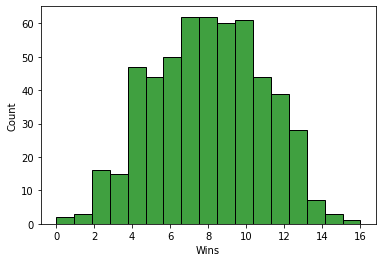

In [232]:
import seaborn as sns

sns.histplot(data['Wins'], color='green')

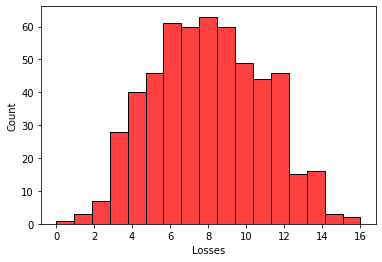

In [233]:
sns.histplot(data['Losses'], color='r')

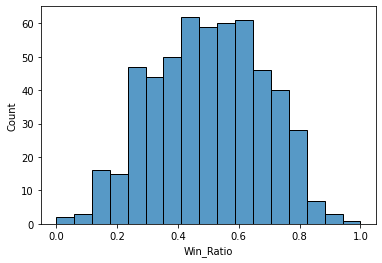

In [234]:
sns.histplot(data['Win_Ratio'])

In [235]:
from sklearn.utils import resample

minority = data[data['SB_Champ_Won Super Bowl'] == 1]
majority = data[data['SB_Champ_Won Super Bowl'] == 0]

# Resample minority class for better balance
min_upsampled = resample(minority,
                         replace=True,
                         n_samples = len(majority),
                         random_state=42)

data_balanced = pd.concat([min_upsampled, majority])

data_balanced['SB_Champ_Won Super Bowl'].value_counts()

1    528
0    528
Name: SB_Champ_Won Super Bowl, dtype: int64

In [236]:
from sklearn.model_selection import train_test_split

def standard_scale(s: pd.Series, mu=None, si=None) -> pd.Series: 
  """
  Calculate mean and standard deviation and standardize the Seres
  """
  mu = s.mean()
  si = s.std()

  return s.apply(lambda x: (x-mu)/si), mu, si

use_cols = ['Win_Ratio']

x_train, x_test, y_train, y_test = train_test_split(data_balanced[use_cols], data_balanced['SB_Champ_Won Super Bowl'], test_size=0.3, random_state=42)

x_train['Win_Ratio_Norm'], mu_wr, si_wr =  standard_scale(x_train['Win_Ratio'])

x_train.drop(columns=['Win_Ratio'], inplace=True)

x_test['Win_Ratio_Norm'], _, _ = standard_scale(x_test['Win_Ratio'], mu=mu_wr, si=si_wr)

x_test.drop(columns=['Win_Ratio'], inplace=True)

In [237]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

logreg = LogisticRegression(random_state=42)

logreg.fit(x_train, y_train)
preds = logreg.predict(x_test)
probs = logreg.predict_proba(x_test)
logreg.score(x_test, y_test)

0.7602523659305994

In [267]:
samp = data['Win_Ratio'].copy()
samp
samp, _, _ = standard_scale(samp, mu=mu_wr, si=si_wr)
samp = pd.DataFrame(samp)
preds = logreg.predict_proba(samp)
data[['Loss Prob', 'Win Prob']] = preds

data.sort_values(by='Win Prob', ascending=False)

,Year,Team,Wins,Losses,Win_Ratio,SB_Champ_Lost Divisional,SB_Champ_Lost WC,SB_Champ_Won Super Bowl,Loss Prob,Win Prob
160,2007,New England Patriots,16,0,1.000,0,0,0,0.002745,0.997255
74,2004,Pittsburgh Steelers,15,1,0.938,0,0,0,0.005951,0.994049
288,2011,Green Bay Packers,15,1,0.938,1,0,0,0.005951,0.994049
416,2015,Carolina Panthers,15,1,0.938,0,0,0,0.005951,0.994049
256,2010,New England Patriots,14,2,0.875,1,0,0,0.013013,0.986987
...,...,...,...,...,...,...,...,...,...,...
185,2007,Miami Dolphins,1,15,0.063,0,0,0,0.997120,0.002880
478,2016,Cleveland Browns,1,15,0.063,0,0,0,0.997120,0.002880
255,2009,St. Louis Rams,1,15,0.063,0,0,0,0.997120,0.002880
218,2008,Detroit Lions,0,16,0.000,0,0,0,0.998690,0.001310


In [271]:
data[data['SB_Champ_Won Super Bowl'] == 1].sort_values(by='Win_Ratio', ascending=False)

,Year,Team,Wins,Losses,Win_Ratio,SB_Champ_Lost Divisional,SB_Champ_Lost WC,SB_Champ_Won Super Bowl,Loss Prob,Win Prob
43,2003,New England Patriots,14,2,0.875,0,0,1,0.013013,0.986987
67,2004,New England Patriots,14,2,0.875,0,0,1,0.013013,0.986987
450,2016,New England Patriots,14,2,0.875,0,0,1,0.013013,0.986987
224,2009,New Orleans Saints,13,3,0.813,0,0,1,0.027875,0.972125
360,2013,Seattle Seahawks,13,3,0.813,0,0,1,0.027875,0.972125
482,2017,Philadelphia Eagles,13,3,0.813,0,0,1,0.027875,0.972125
130,2006,Indianapolis Colts,12,4,0.750,0,0,1,0.059400,0.940600
211,2008,Pittsburgh Steelers,12,4,0.750,0,0,1,0.059400,0.940600
387,2014,New England Patriots,12,4,0.750,0,0,1,0.059400,0.940600
434,2015,Denver Broncos,12,4,0.750,0,0,1,0.059400,0.940600
